<a href="https://colab.research.google.com/github/mikful/dlai-tf-in-practice/blob/master/TensorFlow_in_Practice_S%2BP_Week_3_Lesson_4_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for time series prediction

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# Setup the data series and constants

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

# Split data at the split_time for train/valid sets
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Setup constants for the Single layer NN
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Function to create a windowed dataset
# Takes in a data series, window size and batch size and shuffle and creates a windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
# Train for 100 epochs to find best learning rate

tf.keras.backend.clear_session() # clear any internal variables to allow quick experimentation
tf.random.set_seed(51) # set model seeds for repeatable results
np.random.seed(51)

# Create windowed dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create LSTM with almbda layers:
  # add the required extra input dimension to the timeseries data
  # scale the outputs to the same size as the data to aid in training
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # 64 cell, bidirectional LSTM layer, returning single output
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 32 cell LSTM layer
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Create learning rate callback - increasing over training 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Train model
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 6s 193ms/step - loss: 45.6785 - mae: 46.1983
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 44.3198 - mae: 44.8503
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 42.7381 - mae: 43.2295
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 40.9464 - mae: 41.4185
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 38.8876 - mae: 39.4037
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 36.5755 - mae: 37.1622
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 34.1326 - mae: 34.6631
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 31.4248 - mae: 31.8684
Epoch 9/100
31/31 [==============================] - 0s 15ms/step - loss: 28.1557 - mae: 28.7456
Epoch 10/100
31/31 [==============================] - 0s 15ms/step - loss: 24.7526 - mae: 25.3037
Epoch 11/100
31/31 [========

[1e-08, 0.0001, 0, 30]

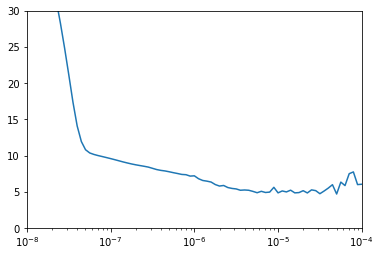

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
# Clear previous values for training
import tensorflow_addons as tfa # for Lookahead optimizer

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# create dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Define LSTM model with Lambda layers to:
  # add the required extra input dimension to the timeseries data
  # scale the outputs to the same size as the data to aid in training
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # 64 cell, bidirectional LSTM layer, returning single output
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 32 cell LSTM layer
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


# Train model - compare optimizers: SGD with learning rate schedule vs adam with lookahead
#optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam()) # lookahead with Adam wins! in accuracy/loss and speed: 5.1 vs 5.6 MAE

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
31/31 [==============================] - 5s 177ms/step - loss: 13.8350 - mae: 14.3924
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 6.5092 - mae: 7.0168
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 5.4037 - mae: 5.8992
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 5.3946 - mae: 5.8778
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 4.8671 - mae: 5.3484
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 5.1534 - mae: 5.6448
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 5.0119 - mae: 5.5112
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 4.6685 - mae: 5.1569
Epoch 9/100
31/31 [==============================] - 1s 18ms/step - loss: 4.9464 - mae: 5.4085
Epoch 10/100
31/31 [==============================] - 1s 17ms

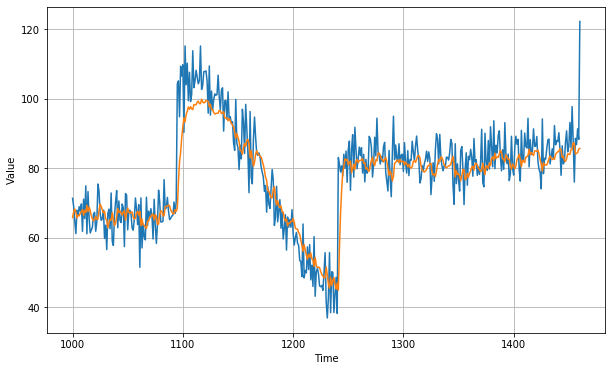

In [15]:
# Predict the next values

forecast = []
results = []
# Iterate over the data by passing in a window size of data and predicting the next value
# Do a standard linear regression to get the result: Y = W0*X0 +.... W19*X19 + b
# add to list
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# As data was split into train/valid, take the valid data after the split time to forecast it
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# plot series
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1134787

<Figure size 432x288 with 0 Axes>

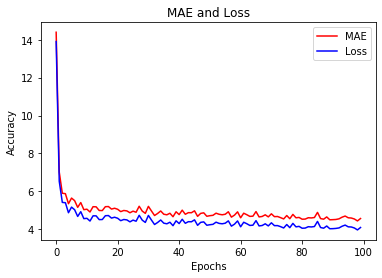

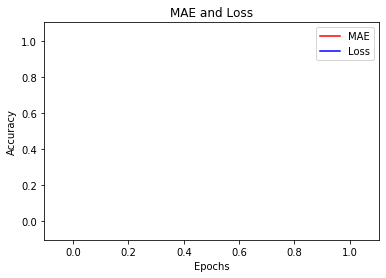

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Now try with 3 layer LSTM - gives worse performance

In [20]:
tf.keras.backend.clear_session()# Clear previous values for training
import tensorflow_addons as tfa # for Lookahead optimizer

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# create dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Define LSTM model with Lambda layers to:
  # add the required extra input dimension to the timeseries data
  # scale the outputs to the same size as the data to aid in training
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # 64 cell, bidirectional LSTM layer, returning single output
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), # 32 cell bidirectional LSTM layer, returning single output
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 32 cell bidirectional LSTM layer
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


# Train model - compare optimizers: SGD with learning rate schedule vs adam with lookahead
#optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam()) # lookahead with Adam wins! in accuracy/loss and speed: 5.1 vs 5.6 MAE

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
31/31 [==============================] - 8s 244ms/step - loss: 13.5363 - mae: 14.1044
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 6.7340 - mae: 7.2471
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 5.7285 - mae: 6.2252
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 5.3944 - mae: 5.8744
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 4.9333 - mae: 5.4152
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 5.3008 - mae: 5.7950
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 4.9793 - mae: 5.4727
Epoch 8/100
31/31 [==============================] - 1s 22ms/step - loss: 4.7074 - mae: 5.1939
Epoch 9/100
31/31 [==============================] - 1s 25ms/step - loss: 4.9152 - mae: 5.3586
Epoch 10/100
31/31 [==============================] - 1s 23ms/step - loss: 4.7648 - mae: 5.2450
Epoch 11/100
31/31 [==========================

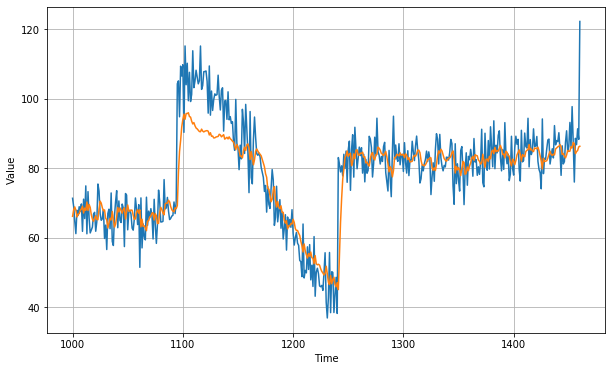

In [21]:
# Predict the next values

forecast = []
results = []
# Iterate over the data by passing in a window size of data and predicting the next value
# Do a standard linear regression to get the result: Y = W0*X0 +.... W19*X19 + b
# add to list
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# As data was split into train/valid, take the valid data after the split time to forecast it
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# plot series
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5436907

<Figure size 432x288 with 0 Axes>

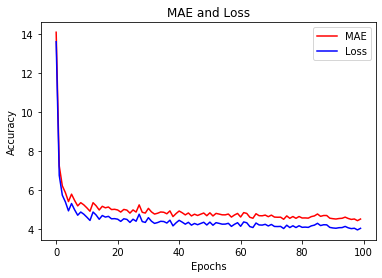

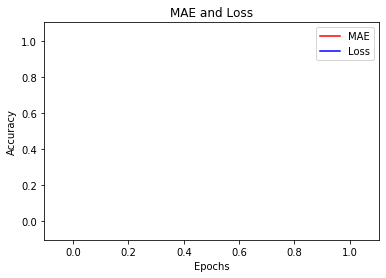

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()